# Lesson 6.4 逻辑回归的正则化建模试验

在补充了一系列关于正则化的基础理论以及sklearn中逻辑回归评估器的参数解释之后，接下来，我们尝试借助sklearn中的逻辑回归评估器，来执行包含特征衍生和正则化过程的建模试验，同时探索模型经验风险和结构风险之间的关系。一方面巩固此前介绍的相关内容，同时也进一步加深对于Pipelinel的理解并熟练对其的使用。当然更关键的一点，本节的实验将为下一小节的网格搜索调参做铺垫，并在后续(Lesso6.6)借助网格搜索工具，给出更加完整、更加自动化、并且效果更好的调参策略。

In [112]:
# 科学计算模块
import numpy as np
import pandas as pd

# 画图模块
import matplotlib.pyplot as plt

# 机器学习模块
from ML_basic_function import *

# Scikit-learn相关模块
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import  PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# 实用函数
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 一、数据准备与评估器构造

首先需要进行数据准备。为了更好的配合进行模型性能与各种方法效果的测试，此处先以手动创建数据集为例进行试验。

### 1.数据准备

在$Lesson 5.1$的阅读部分内容中，我们曾介绍到关于逻辑回归的决策边界实际上就是逻辑回归的线性方程这一特性，并由此探讨了一元函数与二维平面的决策边界之间的关系，据此我们可以创建一个满足决策边界为$y^{2}=x$的分布，创建方法如下：

In [113]:
np.random.seed(24)
x = np.random.normal(0, 1, size=(1000, 2))
y = np.array(x[:, 0] + x[:, 1]**2 < 1.5, dtype='int')

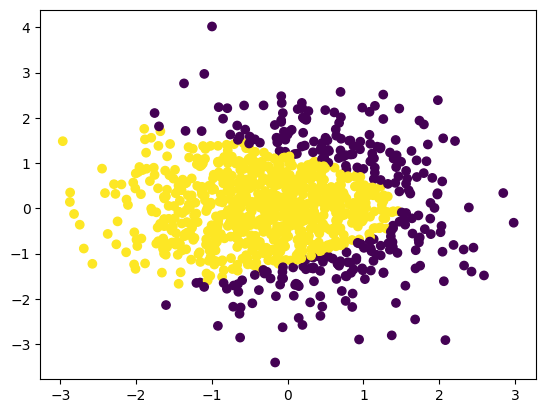

In [114]:
plt.scatter(x[:, 0], x[:, 1], c=y)

此时边界为$y^{2}=一x十1.5$，而选取决策边界的哪一侧为正类哪一侧为负类（即不等号的方向），其实并不影响
后续模型建模。而利用决策边界来划分数据类别，其实也是一种为这个分类数据集赋予一定规律的做法。

同样，为了更好地贴近真实情况，我们在上述决策边界的规律上再人为增加一些扰动项，即让两个类别的决策边界不是那么清晰，相关方法如下：

In [115]:
np.random.seed(24)
for i in range(200):
    y[np.random.randint(1000)] = 1
    y[np.random.randint(1000)] = 0

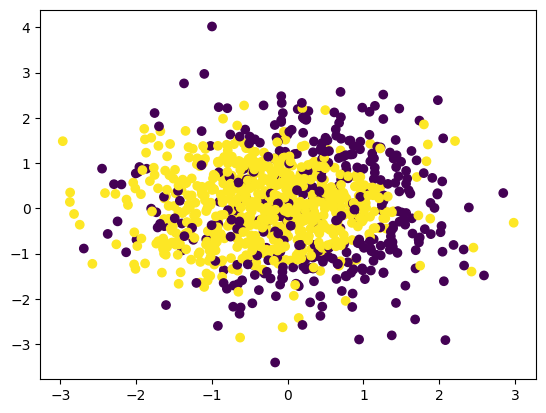

In [116]:
plt.scatter(x[:, 0], x[:, 1], c=y)

当然，如果要增加分类难度，可以选取更多的点随机赋予类别。在整体数据准备完毕后，接下来进行数据集的切分：

In [117]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, train_size=0.7)

至此，数据准备工作全部完成。

### 2、构建机器学习流

接下来，调用逻辑回归中的相关类，来进行模型构建。很明显，面对上述曲线边界的问题，通过简单的逻辑回归无法达到较好的预测效果，因此需要借助此前介绍的PolynomialFeatures:来进行特征衍生，或许能够提升模型表现，此外我们还需要对数据进行标准化处理，以训练过程稳定性及模型训练效率，当然我们还可以通过Pipeline将这些过程封装在一个机器学习流中，以简化调用过程。并且我们知道，整个建模过程我们需要测试在不同强度的数据衍生下，模型是否会出现过拟合倾向，同时如果出现过拟合之后应该如何调整。因此我们可以将上述Pipeline封装在一个函数中，通过该函数我们可以非常便捷进行核心参数的设置，同时也能够重复实例化不同的评估器以支持重复试验。

In [118]:
def plr(degree=1, penalty=None, c=1.0):
    pipe = make_pipeline(PolynomialFeatures(degree= degree, include_bias=False),
                            StandardScaler(),
                            LogisticRegression(penalty=penalty, C=c, max_iter=1000, tol=1e-4))
    return pipe

其中，和数据增强的强度相关的参数是degree,决定了衍生特征的最高阶数，而penalty、C则是逻辑回归中控制正则化及惩罚力度的相关参数，该组参数能够很好的控制模型对于训练数据规律的挖掘程度，当然，最终的建模目标是希望构建一个很好挖掘全局规律的模型，即一方面我们希望模型尽可能挖掘数据规律，另一方面我们又不希望模型过拟合。

> 上述过程有两点需要注意：首先，复杂模型的建模往往会有非常多的参数需要考虑，但一般来说我们会优先考虑影响最终建模效果的参数(如影响模型前拟合、过拟合的参数)，然后再考虑影响训练过程的参数(如调用几核心进行计算、采用何种迭代求解方法等)，前者往往是需要调整的核心参数；其次，上述实例化逻辑回归模型时，我们适当提高了最大迭代次数，这是一般复杂数据建模时都需要调整的参数。

> 合理的设置调参范围，是调好参数的第一步。

## 二、评估器训练与过拟合实验

接下来进行模型训练，并且尝试进行手动调参来控制模型拟合度。

In [119]:
pl1 = plr()

* 更多参数查看和修改方法

当然，函数接口只给了部分核心参数，但如果想调整更多的模型参数，还可以通过使用此前介绍的set_params方法来进行调整：

In [120]:
pl1.get_params()

{'memory': None,
 'steps': [('polynomialfeatures',
   PolynomialFeatures(degree=1, include_bias=False)),
  ('standardscaler', StandardScaler()),
  ('logisticregression', LogisticRegression(max_iter=1000, penalty=None))],
 'verbose': False,
 'polynomialfeatures': PolynomialFeatures(degree=1, include_bias=False),
 'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression(max_iter=1000, penalty=None),
 'polynomialfeatures__degree': 1,
 'polynomialfeatures__include_bias': False,
 'polynomialfeatures__interaction_only': False,
 'polynomialfeatures__order': 'C',
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 1000,
 'logisticregression__multi_class': 'a

* 建模结果观察与决策边界函数

接下来测试模型性能，首先是不进行特征衍生时的逻辑回归建模结果：

In [121]:
pr1 = plr()
pr1.fit(x_train, y_train)
pr1.score(x_train, y_train), pr1.score(x_test, y_test)

(0.6985714285714286, 0.7066666666666667)

我们发现，模型整体拟合效果并不好，我们可以借助此前定义的决策边界来进行一个更加直观的模型建模结果的观察。当然，由于此时我们是调用skea的模型，因此需要在此前的决策边界绘制函数基础上略微进行修改：

In [122]:
def plot_decision_boundary(X, y, model):
    """决策边界绘制函数"""

    # 以两个特征的极值+1/-1为边界，并在其中添加1000个网格点
    x1, x2 = np.meshgrid(np.linspace(X[:, 0].min()-1, X[:, 0].max()+1, 1000).reshape(-1, 1),
                            np.linspace(X[:, 1].min()-1, X[:, 1].max()+1, 1000).reshape(-1, 1))
    # 将所有点的横坐标和纵坐标拉直，并在一起组成一个二维数组
    X_new = np.concatenate([x1.reshape(-1, 1), x2.reshape(-1, 1)], axis=1)
    # 对所有点进行模型类别预测
    yhat_temp = model.predict(X_new)
    yhat = yhat_temp.reshape(x1.shape)

    # 绘制决策边界
    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A', '#FFF59D'])
    plt.contourf(x1, x2, yhat, linewidth=5, cmap=custom_cmap)
    plt.scatter(X[(y==0).flatten(), 0], X[(y==0).flatten(), 1], c='r', label='y=0')
    plt.scatter(X[(y==1).flatten(), 0], X[(y==1).flatten(), 1], c='g', label='y=1')

C:\Users\16179\AppData\Local\Temp\ipykernel_12324\4147990712.py:16: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x1, x2, yhat, linewidth=5, cmap=custom_cmap)


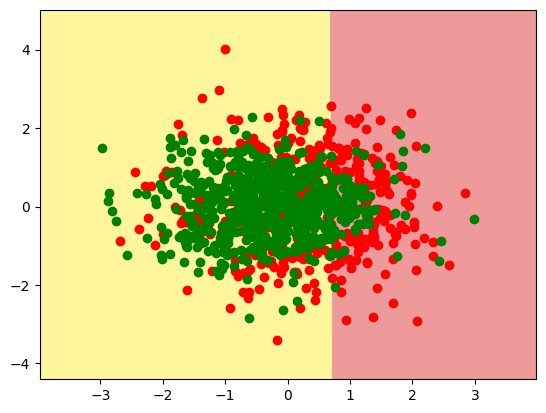

In [123]:
# 测试函数性能
plot_decision_boundary(x, y, pr1)

不难看出，逻辑回归在不进行数据衍生的情况下，只能捕捉线性边界，当然这也是摸型目前性能欠佳的核心原因。当然，我们尝试衍生2次项特征再来进行建模：

In [124]:
pr2 = plr(degree=2)
pr2.fit(x_train, y_train)
pr2.score(x_train, y_train), pr2.score(x_test, y_test)

(0.7914285714285715, 0.7866666666666666)

C:\Users\16179\AppData\Local\Temp\ipykernel_12324\4147990712.py:16: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x1, x2, yhat, linewidth=5, cmap=custom_cmap)


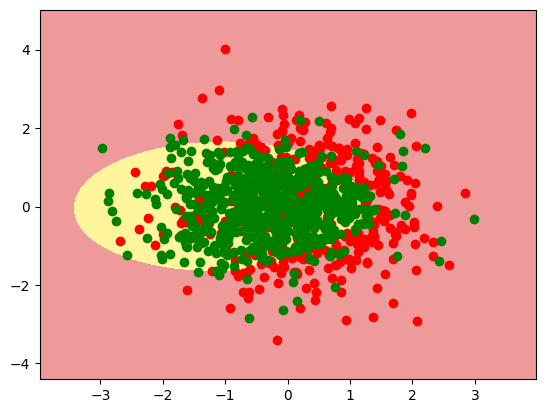

In [125]:
plot_decision_boundary(x, y, pr2)

能够发现，模型效果有了明显提升，这里首先我们可以通过训练完的逻辑回归模型参数个数来验证当前数据特征数量：

In [126]:
pr2.named_steps

{'polynomialfeatures': PolynomialFeatures(include_bias=False),
 'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression(max_iter=1000, penalty=None)}

In [127]:
pr2.named_steps['logisticregression'].coef_

array([[-0.81025989,  0.04397128, -0.48564046,  0.02974179, -1.12341893]])

此处我们可以通过Pipeline中的named_steps来单独调用机器学习流中的某个评估器，从而能够进一步查看该评估器的相关属性，named_steps返回结果同样也是一个字典，通过key来调用对应评估器。当然该字典中的key名称其实是对应评估器类的函数（如果有的话）。最后查看模型总共5个参数，对应训练数据总共5个特征，说明最高次方为二次方、并且存在交叉项目的特征衍生顺利执行。(当前5个特征为$x_{1}、x_{1}^{2}、x_{2}、x_{2}^{2}、x_{1}x_{2})$

而模型在进行特征衍生之后为何会出现一个类似圆形的边界？其实当我们在进行特征衍生的时候，就相当于是将原始数据集投射到一个高维空间，而在高维空间内的逻辑回归摸型，实际上是构建了一个高维空间内的超平面(高维空间的“线性边界)在进行类别划分。而我们现在看到的原始特征空间的决策边界，实际上就是高维空间的决策超平面在当前特征空间的投影。而由此我们也知道了特征衍生至于逻辑回归模型效果提升的实际作用，就是突破了逻辑回归在原始特征空间中的线性边界的束缚。而经过特征衍生的逻辑回归模型，也将在原始特征空间中呈现出非线性的决策边界的特性。

![Alt text](image-112.png)

>需要知道的是，尽管这种特征的衍生看起来很强大，能够帮逻辑回归在原始特征空间中构建非线性的决策边界，但同时需要知道的是，这种非线性边界其实也是受到特征衍生方式的约束的，无论是几阶的特征衍生，能够投射到的高维空间都是有限的，而我们最终也只能在这些有限的高维空间中寻找一个最优的超平面。

* 过拟合倾向实验

当然，我们可以进一步进行10阶特征的衍生，然后构建一个更加复杂的模型：

In [128]:
pr3 = plr(degree=10)
pr3.fit(x_train, y_train)
pr3.score(x_train, y_train), pr3.score(x_test, y_test)

(0.8285714285714286, 0.7866666666666666)

C:\Users\16179\AppData\Local\Temp\ipykernel_12324\4147990712.py:16: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x1, x2, yhat, linewidth=5, cmap=custom_cmap)


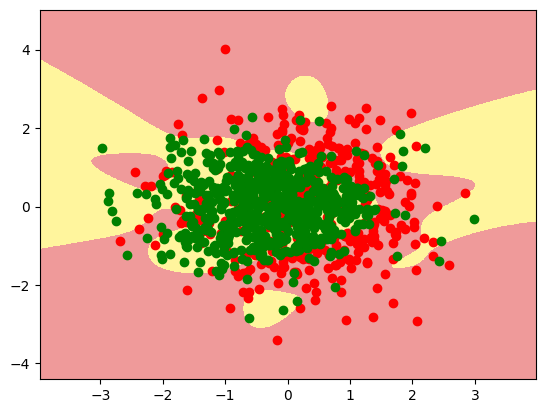

In [129]:
plot_decision_boundary(x, y, pr3)

在基本验证上述代码执行过程无误之后，接下来我们可以尝试通过衍生更高阶特征来提高模型复杂度，并观察在提高模型复杂度的过程中训练误差和测试误差是如何变化的。

In [130]:
# 用于存储不同模型的训练准确率与测试准确率的列表
score_l = []

# 实例化多组模型，测试模型效果
for i in range(1, 21):
    pr_temp = plr(degree=i)
    pr_temp.fit(x_train, y_train)
    score_l.append((pr_temp.score(x_train, y_train), pr_temp.score(x_test, y_test)))
    

e:\Anaconda\envs\MachineLearning\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
e:\Anaconda\envs\MachineLearning\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

In [131]:
np.array(score_l)

array([[0.69857143, 0.70666667],
       [0.79142857, 0.78666667],
       [0.79428571, 0.78333333],
       [0.79428571, 0.78333333],
       [0.79428571, 0.77666667],
       [0.80428571, 0.79      ],
       [0.80285714, 0.78      ],
       [0.82714286, 0.77333333],
       [0.83      , 0.76333333],
       [0.82857143, 0.78666667],
       [0.83285714, 0.78333333],
       [0.83      , 0.78666667],
       [0.83142857, 0.78      ],
       [0.83      , 0.78666667],
       [0.82857143, 0.78666667],
       [0.82571429, 0.78333333],
       [0.83      , 0.78666667],
       [0.82857143, 0.78333333],
       [0.83571429, 0.78666667],
       [0.83      , 0.78333333]])

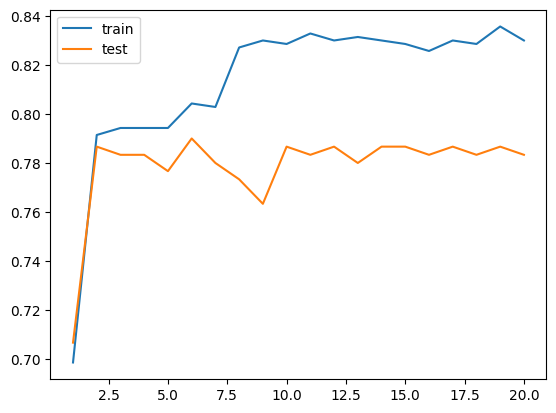

In [132]:
plt.plot(np.arange(1, 21), np.array(score_l)[:, 0], label='train')
plt.plot(np.arange(1, 21), np.array(score_l)[:, 1], label='test')
plt.legend()

最终，我们能够较为明显的看出，伴随着模型越来越复杂（特征越来越多），训练集准确率逐渐提升，但测试集准确率却在一段时间后开始下降，说明模型经历了由开始的欠拟合到拟合再到过拟合的过程，和上一小节介绍的模型结构风险伴随模型复杂度提升而提升的结论一致。

![Alt text](image-113.png)

而接下来的问题就是，如何同时控制结构风险和经验风险。根据上一小节的介绍，采用正则化将是一个不错的选择，当然我们也可以直接从上图中的曲线变化情况来挑选最佳的特征衍生个数。接下来，我们尝试对上述模型进行手动调参。

## 三、评估器的手动调参

根据上一小节的介绍，我们知道，对于过拟合，我们可以通过门或2正则化来抑制过拟合影响，并且从上一小节我们得知，一个比较好的建模流程是先进行数据增强（特征衍生），来提升模型表现，然后再通过正则化的方式来抑制过拟合倾向。接下来，我们就上述问题来进行相关尝试

* 验证正则化对过拟合的抑制效果

In [133]:
# 测试l1正则化
pl1 = plr(penalty='l1', c=0.1, degree=10)

In [134]:
pl1.set_params(logisticregression__solver='saga').fit(x_train, y_train)

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=10, include_bias=False)),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=1000, penalty='l1',
                                    solver='saga'))])

In [135]:
pl1.score(x_train, y_train), pl1.score(x_test, y_test)

(0.7857142857142857, 0.7933333333333333)

In [136]:
# 测试l2正则化
pl2 = plr(penalty='l2', c=0.1, degree=10)
pl2.fit(x_train, y_train)
pl2.score(x_train, y_train), pl2.score(x_test, y_test)

(0.79, 0.7866666666666666)

尽管从决策边界上观察并不明显，但从最终建模结果来看，正则化确实起到了抑制过拟合的效果。接下来我们尝试手动对上述模型进行调参，尝试能否提高模型表现。此处我们采用一个非常朴素的想法来进行调参，即使用degree、C和正则化选项(l1或l2)的不同组合来进行调参，试图从中选择一组能够让模型表现最好的参数，并且先从degree开始进行搜索：

* l1正则化下最优特征衍生阶数

In [137]:
# 用于存储不同模型的训练准确率与测试准确率的列表
score_l = []

# 实例化多组模型，测试模型效果
for i in range(1, 21):
    pl_temp = plr(penalty='l1', degree=i)
    pl_temp.set_params(logisticregression__solver='saga')
    pl_temp.fit(x_train, y_train)
    score_l.append((pl_temp.score(x_train, y_train), pl_temp.score(x_test, y_test)))

e:\Anaconda\envs\MachineLearning\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
e:\Anaconda\envs\MachineLearning\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
e:\Anaconda\envs\MachineLearning\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
e:\Anaconda\envs\MachineLearning\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
e:\Anaconda\envs\MachineLearning\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
e:\Anaconda\envs\MachineLearning\lib\site-packages\sklearn\linear_mode

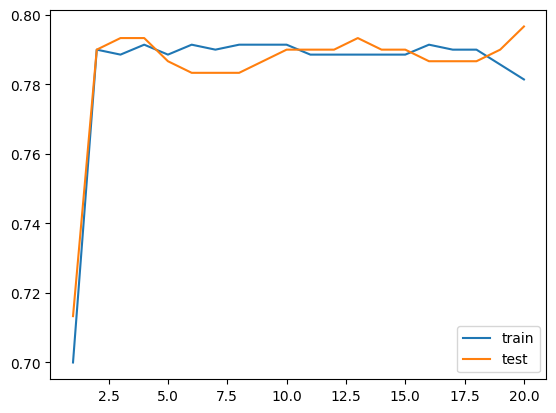

In [138]:
# 观察模型效果
plt.plot(np.arange(1, 21), np.array(score_l)[:, 0], label='train')
plt.plot(np.arange(1, 21), np.array(score_l)[:, 1], label='test')
plt.legend()


In [139]:
score_l

[(0.7, 0.7133333333333334),
 (0.79, 0.79),
 (0.7885714285714286, 0.7933333333333333),
 (0.7914285714285715, 0.7933333333333333),
 (0.7885714285714286, 0.7866666666666666),
 (0.7914285714285715, 0.7833333333333333),
 (0.79, 0.7833333333333333),
 (0.7914285714285715, 0.7833333333333333),
 (0.7914285714285715, 0.7866666666666666),
 (0.7914285714285715, 0.79),
 (0.7885714285714286, 0.79),
 (0.7885714285714286, 0.79),
 (0.7885714285714286, 0.7933333333333333),
 (0.7885714285714286, 0.79),
 (0.7885714285714286, 0.79),
 (0.7914285714285715, 0.7866666666666666),
 (0.79, 0.7866666666666666),
 (0.79, 0.7866666666666666),
 (0.7857142857142857, 0.79),
 (0.7814285714285715, 0.7966666666666666)]

* 手动调参评价

尽管上述过程能够帮助我们最终找到一组相对比较好的参数组合，最终建模结果相比此前，也略有提升，但上述手动调参过程存在三个致命问题：

(1)过程不够严谨，诸如测试集中测试结果不能指导建模、参数选取及搜索区间选取没有理论依据等问题仍然存在；

(2)执行效率太低，如果面对更多的参数（这是更一般的情况），手动执行过程效率太低，无法进行超大规模的参数挑选；

(3)结果不够精确，一次建模结果本身可信度其实并不高，我们很难证明上述挑选出来的参数就一定在未来数据预测中拥有较高准确率。

而要解决这些问题，我们就需要补充关于机器学习调参的理论基础，以及掌握更多更高效的调参工具。正因如此，我们将在下一小节详细介绍关于机器学习调参的基本理论以及sklearn中的网格搜索调参工具，而后我们再借助更完整的理论、更高效的工具对上述问题进行解决。